## EMoody: Detección de emociones a través de la voz
#### Proyecto Final de Grado del grado en Ingeniería Matemática Aplicada al Análisis de Datos - notebook por Marta Almendro Álvarez

### Introducción

El objetivo del presente trabajo es desarrollar una herramienta capaz de detectar las emociones a través de una muestra de voz. Para ello se utiliza la arquitectura de una red neuronal artificial como clasificador, compuesta por la mezcla de dos tipos de redes:

- Red neuronal convolucional (**CNN**)
- Red neuronal recurrente (**RNN**)

La disciplina de reconocimiento automático de las emociones humanas a través de la voz es es como Speech Emotion Recognition (SER). Se basa en la idea de que el tono de voz puede contener emociones subyacentes. Esta disciplina esta ganando cada vez más popularidad y demanda. Desde hace tiempo se han estado empleando técnicas de Machine Learning, pero estudios más recientes revelan la eminente capacidad del Deep Learning de resolever estos problemas, obteniendo mejores resultados a través de sistemas más rápidos y eficientes. Este estudio es un ejemplo de la aplicación de este tipo de algoritmos para detectar emociones en base a datos de voz. 

#### Datasets utilizados

- Crowd-sourced Emotional Mutimodal Actors Dataset (**CREMA-D**):

Crema-D es un conjunto de datos de 7,442 archivos de 91 actores. Las voces las componen 48 actores masculinos y 43 femeninos entre las edades de 20 y 74, provenientes de una variedad de razas y etnias (afroamericanos, asiáticos, caucásicos, hispanos y no especificados). Los actores hablan una selección de 12 frases expresadas en una de seis emociones diferentes (ira, disgusto, miedo, feliz, neutral y triste) 

- Ryerson Audio-Visual Database of Emotional Speech and Song (**RAVDESS**):

La RAVDESS contiene 7356 archivos, en los que participan 24 actores profesionales (12 mujeres, 12 hombres) con un acento norteamericano neutral. Los archivos de voz incluyen expresiones de calma, felicidad, tristeza, ira, miedo, sorpresa y disgusto, y se vocaliza una de dos frases posibles. El archivo de voz (Audio_Speech_Actors_01-24.zip, 215 MB) contiene 1440 archivos: 60 ensayos por actor x 24 actores = 1440.

#### Librerías requeridas

In [1]:
# Interactuar con el sistema operativos
import os

# Algebra lineal, procesamiento de datos y visualizaciones
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis de audio y extracción de características
import librosa 
import librosa.display

# Reproducción de audio
from IPython.display import Audio
plt.style.use('seaborn-white')

# Suprimir warnings
import warnings
warnings.filterwarnings("ignore")

# Oversampling
from imblearn.over_sampling import SMOTE

# Preparación de datos para ML
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Librerías para el modelado Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, AveragePooling1D, LSTM, Activation
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# Evaluación de modelos
from sklearn.metrics import confusion_matrix, classification_report

### Lectura de los datos y análisis preliminar

Ya que se trabaja con dos datasets diferentes, se centralizan todos los datos en un mismo dataframe con las emociones y sus respectivos paths para cada dataset. Este dataset final es el que se utilizará durante la fase de extracción de características.

In [2]:
# Paths a los datos
CREMA_D = "./data/cremad/AudioWAV/"
RAVDESS = "./data/ravdess/Audio_Speech_Actors_01-24/"

#### Crema-D

Pautas de identificación de los archivos CREMA-D:

**1. ID del actor** (Número de 4 dígitos. Los IDs 1002-1013,1018,1020,1021,1024,1025,1028-1030,1037,1043,1046,1047,1049, 1052-1056,1058,1060,1061,1063,1072-1076,1078,1079,1082,1084,1089,1091 corresponden al sexo femenino, y el resto al masculino)

**2. Frase**:
- “It's eleven o'clock” (IEO).
- “That is exactly what happened” (TIE).
- “I'm on my way to the meeting” (IOM).
- “I wonder what this is about” (IWW).
- “The airplane is almost full” (TAI).
- “Maybe tomorrow it will be cold” (MTI).
- “I would like a new alarm clock” (IWL)
- “I think I have a doctor's appointment” (ITH).
- “Don't forget a jacket” (DFA).
- “I think I've seen this before” (ITS).
- “The surface is slick” (TSI).
- “We'll stop in a couple of minutes” (WSI)

**3. Emocion** (Enfado (ANG), Disgusto (DIS), Miedo (FEA), Feliz (HAP), Neutro (NEU), Triste (SAD))

**4. Nivel de emoción** ( Bajo (LO), Medio (MD), Alto (HI), Sin especificar (XX))

In [3]:
crema_directory = os.listdir(CREMA_D)

# IDs de voces de mujer
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]
males = []
females = []

# Filtrar los archivos y separar por emociones
for file in crema_directory: 
    part = file.split('_')   
    
    if part[2] == 'SAD':
        emotion = 'sad'
    elif part[2] == 'ANG':
        emotion = 'angry'
    elif part[2] == 'DIS':
        emotion = 'disgust'
    elif part[2] == 'FEA':
        emotion = 'fear'
    elif part[2] == 'HAP':
        emotion = 'happy'
    elif part[2] == 'NEU':
        emotion = 'neutral'  
    else:
        emotion = 'unknown'
    
    # Filtrar mujeres
    if int(part[0]) in female:
        path = (CREMA_D + '/' + file)
        females.append([emotion, path]) 
    # Filtrar hombres    
    else:
        path = (CREMA_D + '/' + file)
        males.append([emotion, path])   

# Datasets finales con labels (emociones) y los paths de los archivos de voz
# Mujeres
CremaFemales_df = pd.DataFrame(females)
CremaFemales_df.columns = ['labels', 'path']

# Hombres
CremaMales_df = pd.DataFrame(males)
CremaMales_df.columns = ['labels', 'path']

In [4]:
print('CREMA-D dataset mujeres')
CremaFemales_df.head()

CREMA-D dataset mujeres


labels                                         path
0    angry  ./data/cremad/AudioWAV//1002_DFA_ANG_XX.wav
1  disgust  ./data/cremad/AudioWAV//1002_DFA_DIS_XX.wav
2     fear  ./data/cremad/AudioWAV//1002_DFA_FEA_XX.wav
3    happy  ./data/cremad/AudioWAV//1002_DFA_HAP_XX.wav
4  neutral  ./data/cremad/AudioWAV//1002_DFA_NEU_XX.wav

In [5]:
print('CREMA-D dataset hombres')
CremaMales_df.head()

CREMA-D dataset hombres


labels                                         path
0    angry  ./data/cremad/AudioWAV//1001_DFA_ANG_XX.wav
1  disgust  ./data/cremad/AudioWAV//1001_DFA_DIS_XX.wav
2     fear  ./data/cremad/AudioWAV//1001_DFA_FEA_XX.wav
3    happy  ./data/cremad/AudioWAV//1001_DFA_HAP_XX.wav
4  neutral  ./data/cremad/AudioWAV//1001_DFA_NEU_XX.wav

#### Ravdess

 Los archivos de este dataset siguen las siguientes pautas de identificación:

**1. Modalidad** (01 = full-AV, 02 = video-only, 03 = audio-only) - este proyecto emplea la modalidad 03

**2. Canal vocal** (01 = speech, 02 = song) - este proyecto emplea la modalidad de habla (01)

**3. Emocion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

**4. Intensidad emocional** (01 = normal, 02 = strong)

**5. Frase** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")

**6. Repetición** (01 = 1st repetition, 02 = 2nd repetition)

**7. Actor** (01 to 24) - Números impares son hombres, los pares son mujeres

In [6]:
ravdess_directory = os.listdir(RAVDESS)

males = []
females = [] 

# Filtrar los archivos y separar por emociones
for actor in ravdess_directory:
       
    files = os.listdir(RAVDESS + actor)
        
    for file in files: 
        part = file.split('.')[0]
        part = part.split("-")           
                
        if part[2] == '01':
            emotion = 'neutral'
        elif part[2] == '02':
            emotion = 'calm'
        elif part[2] == '03':
            emotion = 'happy'
        elif part[2] == '04':
            emotion = 'sad'
        elif part[2] == '05':
            emotion = 'angry'
        elif part[2] == '06':
            emotion = 'fear'
        elif part[2] == '07':
            emotion = 'disgust'
        elif part[2] == '08':
            emotion = 'surprise'
        else:
            emotion = 'unknown'
        
        ifeven = int(part[6])
        
        # Filtrar mujeres
        if ifeven%2 == 0:
            path = (RAVDESS + actor + '/' + file)
            females.append([emotion, path])    
        # Filtrar hombres
        else:
            path = (RAVDESS + actor + '/' + file)
            males.append([emotion, path])   

# Datasets finales con labels (emociones) y los paths de los archivos de voz
# Mujeres
RavFemales_df = pd.DataFrame(females)
RavFemales_df.columns = ['labels', 'path']

# Hombres
RavMales_df = pd.DataFrame(males)
RavMales_df.columns = ['labels', 'path']

In [7]:
print('RAVDESS dataset mujeres')
RavFemales_df.head()

RAVDESS dataset mujeres


labels                                               path
0  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
1  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
2  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
3  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
4     calm  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...

In [8]:
print('RAVDESS dataset hombres')
RavMales_df.head()

RAVDESS dataset hombres


labels                                               path
0  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
1  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
2  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
3  neutral  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...
4     calm  ./data/ravdess/Audio_Speech_Actors_01-24/Actor...

Por ultimo se fusionan los dataframes de tal manera que se tenga un dataframe conjunto para cada uno de los géneros. Estos datasets se guardan en formato csv para poder ser guardados e importados más adelante de forma más fácil y cómoda.

In [9]:
# Fusión de dataframes
Female_df = pd.concat([RavFemales_df, CremaFemales_df], axis = 0)
Female_df.to_csv("females_emotions_df.csv", index = False)

Male_df = pd.concat([RavMales_df, CremaMales_df], axis = 0)
Male_df.to_csv("males_emotions_df.csv", index = False)

### Exploración y visualización de datos

Para un análisis general del conteo de cada emoción se emplean gráficos de barras:

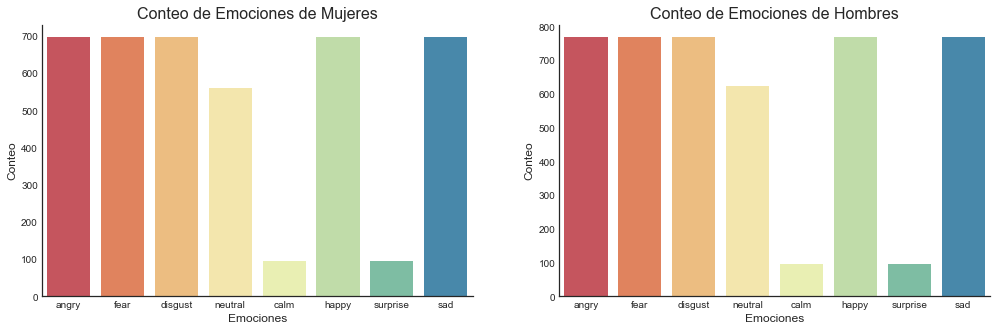

In [10]:
order = ['angry','fear','disgust','neutral','calm','happy','surprise','sad']

fig = plt.figure(figsize=(17, 5))

# Diagrama de barras de emociones de mujeres
fig.add_subplot(121)
plt.title('Conteo de Emociones de Mujeres', size=16)
sns.countplot(Female_df.labels, order = order, palette="Spectral")
plt.ylabel('Conteo', size=12)
plt.xlabel('Emociones', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Diagrama de barras de emociones de hombres
fig.add_subplot(122)
plt.title('Conteo de Emociones de Hombres', size=16)
sns.countplot(Male_df.labels, order = order, palette="Spectral")
plt.ylabel('Conteo', size=12)
plt.xlabel('Emociones', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Gráfico conjunto
plt.show()

Existe un claro desnivel en el número de emociones de *calm* y *suprise* en comparación con el resto. Más adelante se aplicarán las técnicas necesarias para solucionar este desbalance de clases.

Para saber cuantos datos existen exactamente para cada emoción se muestran las cifras para hombres y mujeres.

In [11]:
Female_df['labels'].value_counts()

fear        696
disgust     696
happy       696
sad         696
angry       696
neutral     560
surprise     96
calm         96
Name: labels, dtype: int64

In [12]:
Male_df['labels'].value_counts()

fear        767
disgust     767
happy       767
sad         767
angry       767
neutral     623
surprise     96
calm         96
Name: labels, dtype: int64

#### Gráficos de onda y espectrogramas

- **Gráficos de onda**: muestran lo alto que es un sonido (en este caso la voz) en cierto momento
- **Espectrograma**: representación visual del espectro de frecuencias del sonido a lo largo que varían en el tiempo.

In [13]:
# Una función para crear los gráficos de onda
def create_waveplot(data, sr, e, g):
    plt.figure(figsize=(14,4))
    plt.title('Gráfico de onda para la emoción {} ({})'.format(e, g), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

# Función para crear los espectrogramas
def create_spectrogram(data, sr, e, g):
    # stft somete a los datos a la tranformada corta de fourier
    X = librosa.stft(data)
    # convierte a decibelios para que la escala sea logarítmica
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14,4))
    plt.title('Espectrograma para la emoción {} ({})'.format(e, g), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

##### Audio: Miedo

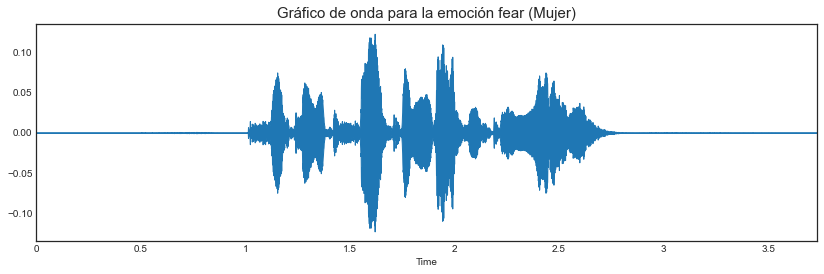

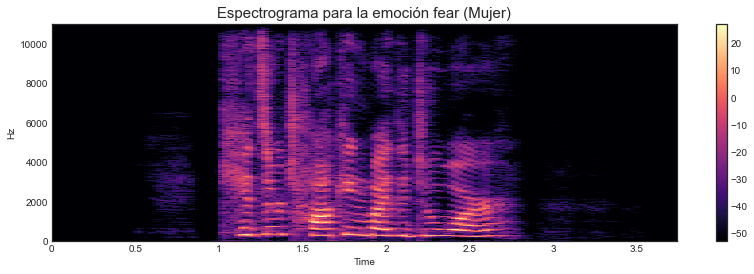

In [14]:
emotion = 'fear'
gender = 'Mujer'

path = np.array(Female_df.path[Female_df.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, gender)
create_spectrogram(data, sampling_rate, emotion, gender)
Audio(path)

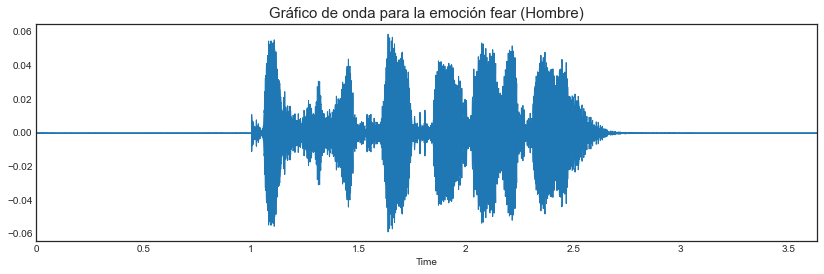

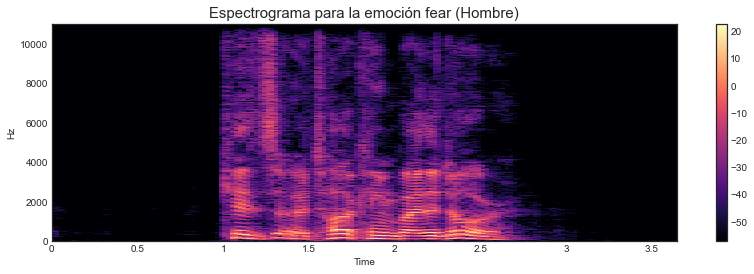

In [15]:
emotion = 'fear'
gender = 'Hombre'

path = np.array(Male_df.path[Male_df.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, gender)
create_spectrogram(data, sampling_rate, emotion, gender)
Audio(path)

##### Audio: Felicidad

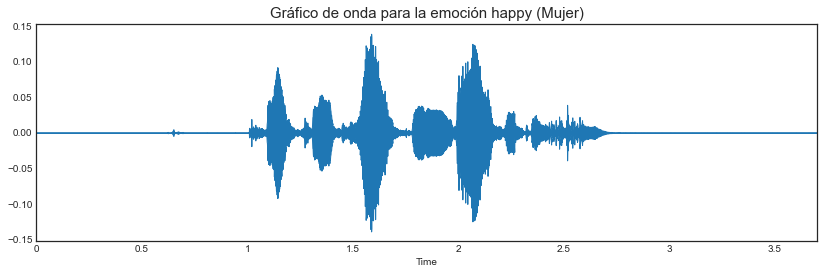

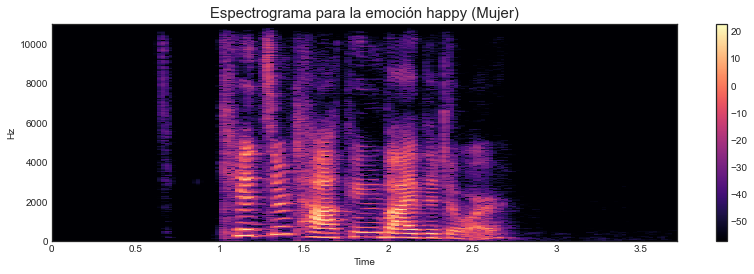

In [16]:
emotion='happy'
gender = 'Mujer'

path = np.array(Female_df.path[Female_df.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, gender)
create_spectrogram(data, sampling_rate, emotion, gender)
Audio(path)

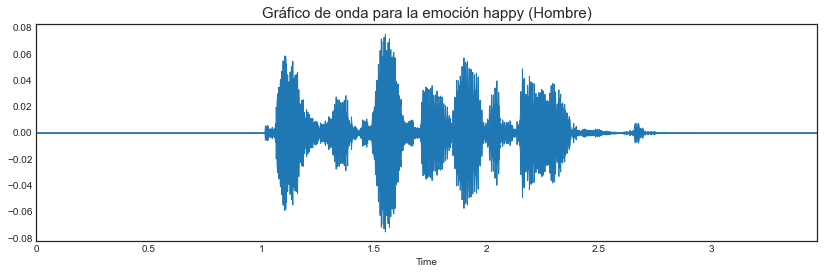

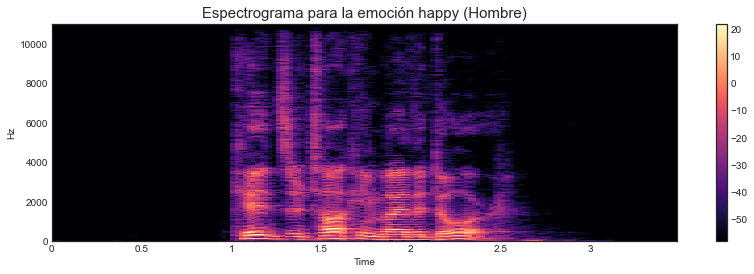

In [17]:
emotion = 'happy'
gender = 'Hombre'

path = np.array(Male_df.path[Male_df.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, gender)
create_spectrogram(data, sampling_rate, emotion, gender)
Audio(path)

El propósito de visualizar asi las emociones es para detectar que en efecto, existen diferencias en la forma que toma cada uno, mostrando incluso una clara diferencia en cuanto a género.

Un modelo no puede entender la información recibida en formato de audio, por lo tanto, es crucial convertir estos datos en un formato entendible. Para ello se utiliza la extracción de características, conocido como **Feature Extraction** (más adelante).

### Generación de datos artificiales (Data Augmentation)

Uno de los objetivos es hacer un modelo invariante a las posibles perturbaciones que pueden encontrarse en muestras de audio. Las técnicas de Data Augmentation se utilizan para crear nuevos datos sintéticos de entrenamiento añadiendo pequeñas perturbaciones a los datos iniciales: esto da lugar a una mayor precisión y a una mayor generalización.

A continuación se prueban varias técnicas de augmentation y se muestra el efecto que tienen en los datos originales. Para ello se emplea otra vez la librería *librosa*, especial para el tratado de datos de audio.

In [18]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, speed_factor)

In [19]:
# Escoger muestras de ambos sexos para hacer pruebas
pathFemale = np.array(Female_df.path)[1]
dataF, sample_rateF = librosa.load(pathFemale)

pathMale = np.array(Male_df.path)[1]
dataM, sample_rateM = librosa.load(pathMale)

##### Data Augmentation: Noise injection

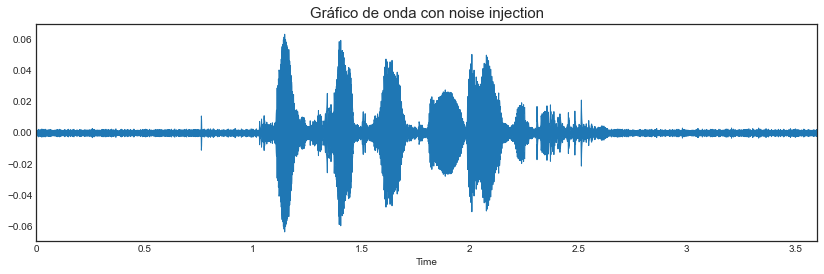

In [20]:
x = noise(dataF)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rateF)
plt.title('Gráfico de onda con noise injection', size=15)
Audio(x, rate=sample_rateF)

##### Data Augmentation: Stretch

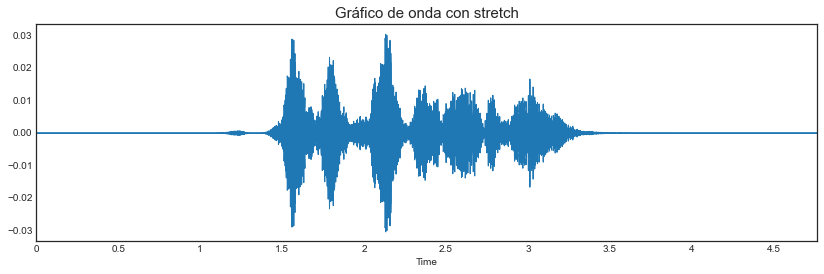

In [21]:
x = stretch(dataM)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rateM)
plt.title('Gráfico de onda con stretch', size=15)
Audio(x, rate=sample_rateM)

##### Data Augmentation: Shift

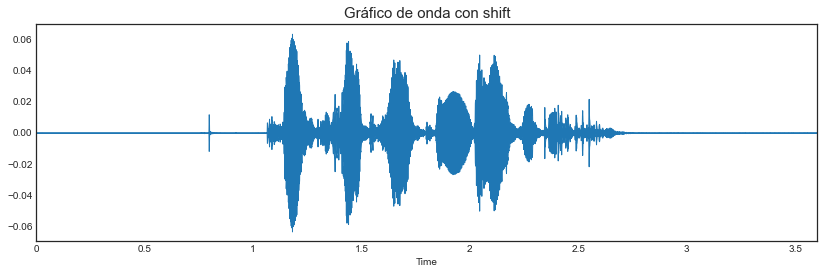

In [22]:
x = shift(dataF)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rateF)
plt.title('Gráfico de onda con shift', size=15)
Audio(x, rate=sample_rateF)

##### Data Augmentation: Pitch

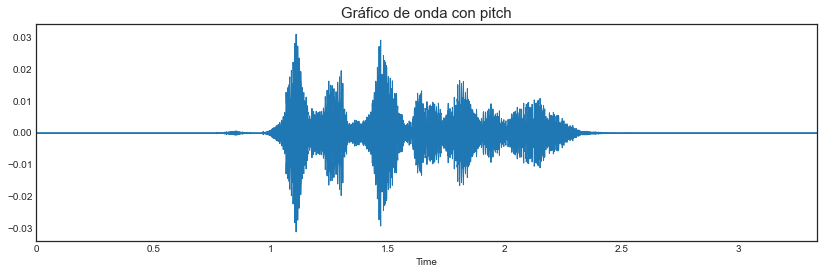

In [23]:
x = pitch(dataM, sample_rateM)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rateM)
plt.title('Gráfico de onda con pitch', size=15)
Audio(x, rate=sample_rateM)

##### Data Augmentation: Higher speed

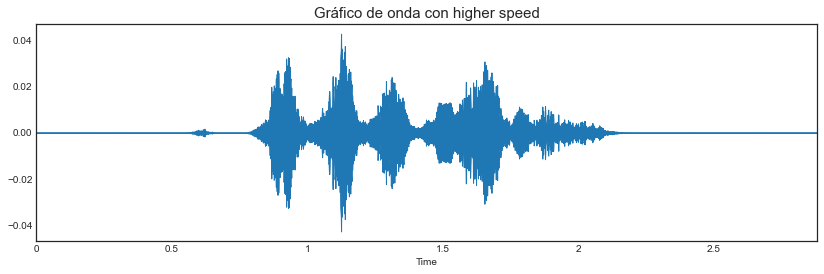

In [24]:
x = higher_speed(dataF)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rateF)
plt.title('Gráfico de onda con higher speed', size=15)
Audio(x, rate=sample_rateF)

##### Data Augmentation: Lower speed

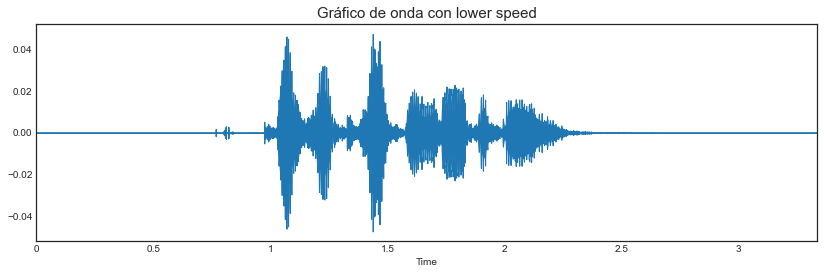

In [25]:
x = shift(dataM)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rateM)
plt.title('Gráfico de onda con lower speed', size=15)
Audio(x, rate=sample_rateM)

Se decide aplicar todas las tecnicas mostradas ya que se considera que todas son variaciones que se va a poder encontrar la herramienta final a la hora de captar audio a través de dispositivos de usuarios independientes.

### Extracción de características (Feature Extraction)

La extracción de características es una parte fundamental en tareas de reconocimiento de voz. Para este proyecto, se persigue aplicar los beneficios de las características MFCC. Realizar una extracción de características empleando muchas técnicas resulta distorsionar demasiado la información contenida en los audios.

Para extraer los coeficientes MFCC se emplea una vez más la librería *librosa* que ofrece una función para ello y en la que se pueden ajustar distintos parámetros para adecuarla al formato de audio con el que se trabaja.

A continuación se muestran ejemplos de espectrogramas tras la extracción de coeficientes MFCC de los audios.

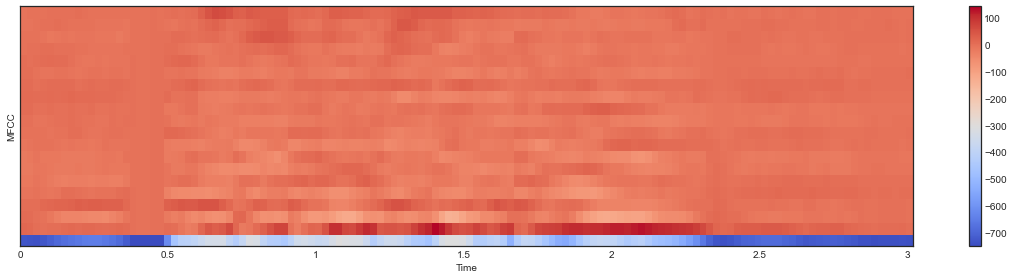

In [26]:
emotion = 'fear'

# Prueba con 20 coeficientes
pathFemale = np.array(Female_df.path[Female_df.labels==emotion])[1]
dataF, sample_rateF = librosa.load(pathFemale, duration=3, offset=0.5, res_type='kaiser_fast')
mfccs_fear = librosa.feature.mfcc(y=dataF, sr=sample_rateF, n_mfcc=20)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)

librosa.display.specshow(mfccs_fear, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

Las zonas oscuras son las que muestran formantes en el espectro; los sonidos se pueden identificar mucho mejor a través de los formantes y sus transiciones. Con 20 coeficientes no se distinguen muy bien, por lo que se opta por la extracción de 50 MFCCs de cada muestra de audio (esta conclusión esta respaldada por resultados de entrenamiento más bajos con menos de 50 coeficientes).

##### Feature Extraction: MFCC Spectogram (fear)

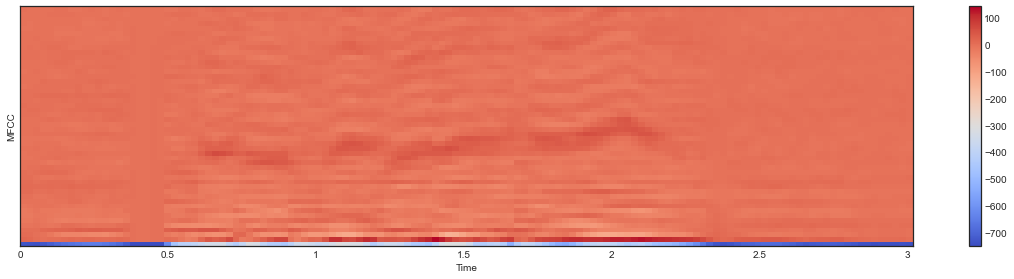

In [27]:
emotion = 'fear'

# Extracción de 50 coeficientes
pathFemale = np.array(Female_df.path[Female_df.labels==emotion])[1]
dataF, sample_rateF = librosa.load(pathFemale, duration=3, offset=0.5, res_type='kaiser_fast')
mfccs_fear = librosa.feature.mfcc(y=dataF, sr=sample_rateF, n_mfcc=50)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)

librosa.display.specshow(mfccs_fear, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

##### Feature Extraction: MFCC Spectogram (surprise)

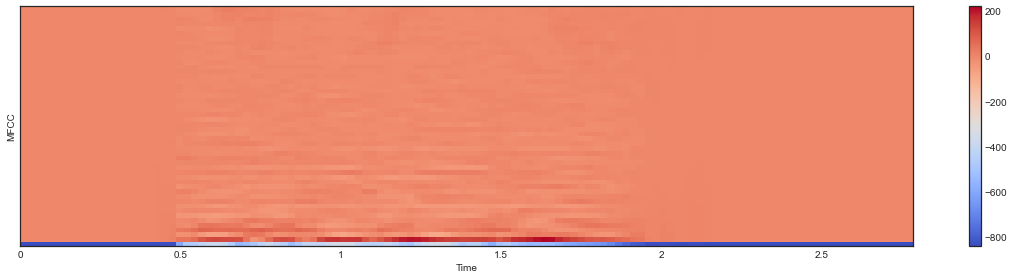

In [28]:
emotion = 'surprise'

pathMale = np.array(Male_df.path[Male_df.labels==emotion])[1]
dataM, sample_rateM = librosa.load(pathMale, duration=3, offset=0.5, res_type='kaiser_fast')
mfccs_surprise = librosa.feature.mfcc(y=dataM, sr=sample_rateM, n_mfcc=50)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)

librosa.display.specshow(mfccs_surprise, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

##### Feature Extraction: MFCC Spectogram (anger - male)

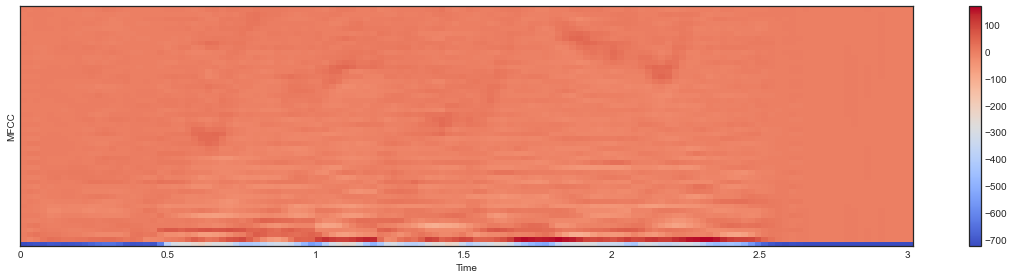

In [29]:
emotion = 'angry'

pathMale = np.array(Male_df.path[Male_df.labels==emotion])[1]
dataM, sample_rateM = librosa.load(pathMale, duration=3, offset=0.5, res_type='kaiser_fast')
mfccs_anger_male = librosa.feature.mfcc(y=dataM, sr=sample_rateM, n_mfcc=50)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)

librosa.display.specshow(mfccs_anger_male, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

##### Feature Extraction: MFCC Spectogram (anger - female)

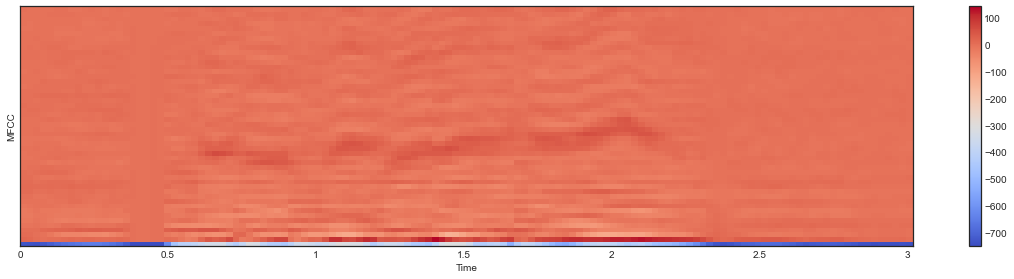

In [30]:
emotion = 'angry'

pathFemale = np.array(Female_df.path[Female_df.labels==emotion])[1]
dataM, sample_rateM = librosa.load(pathFemale, duration=3, offset=0.5, res_type='kaiser_fast')
mfccs_anger_female = librosa.feature.mfcc(y=dataF, sr=sample_rateF, n_mfcc=50)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)

librosa.display.specshow(mfccs_anger_female, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

Tras analizar los espectrogramas de MFFCs y llegar a la conclusion de que se van a extraer 50 coeficientes, se procede a extraer estas caracteristicas al conjunto de datos preparado anteriormente, añadiendo a su vez las tecnicas de creación de datos sintéticos. Con esto están preparados los datasets finales de entrenamiento.

A su vez se realiza una comparativa del comportamiento de estos coeficientes MFCC a lo laargo del periodo especificado para hombres y mujeres a través de un gráfico de líneas con la media de los valores de los MFCCs.

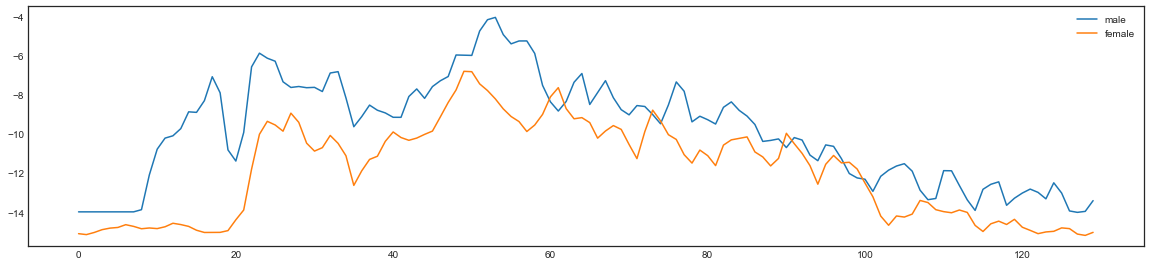

In [31]:
mfccs_anger_male = np.mean(librosa.feature.mfcc(y=dataM, sr=sample_rateM, n_mfcc=50), axis=0)
mfccs_anger_female = np.mean(librosa.feature.mfcc(y=dataF, sr=sample_rateF, n_mfcc=50), axis=0)

# Comparativa coeficientes MFCC entre sexos (emoción de enfado)
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(mfccs_anger_male, label='male')
plt.plot(mfccs_anger_female, label='female')
plt.legend()

Con los análisis realizados se demuestra que existen destacadas diferencias en el comportamiento de las frecuencias y las caracteristicas de la voz en hombres y mujeres, lo cual puede ser un factor importante a la hora de evaluar el desempeño de los modelos más adelante.

In [32]:
# Extraer coeficientes MFCC
def extract_features(data, sample_rate):
    
    result = np.array([])
    
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=50)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

def get_features(path):
    # Se establece la cantidad de audio que cargar (duration) y desde donde empezar a captar el audio (offset)
    data, sample_rate = librosa.load(path, duration=3, offset=0.5, res_type='kaiser_fast') 
    
    # Sin augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Añadir ruido
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    # se apilan los arrays verticalmente
    result = np.vstack((result, res2))
    
    # Estirar
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data, sample_rate)
    result = np.vstack((result, res3))
    
    # Desplazar audio
    shift_data = shift(data)
    res4 = extract_features(shift_data, sample_rate)
    result = np.vstack((result, res4))
    
    # Cambios de tono
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data, sample_rate)
    result = np.vstack((result, res5)) 
    
    # Añadir velocidad
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data, sample_rate)
    result = np.vstack((result, res6))
    
    # Reducir velocidad
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data, sample_rate)
    result = np.vstack((result, res7))
    
    return result

In [33]:
# Data augmentation y feature extraction de audios de mujeres
female_X, female_Y = [], []

for path, emotion in zip(Female_df.path, Female_df.labels):
    features = get_features(path)
    # Añadir augmentation y extracción de características devuelve un array multi dimensional lo que requiere un bucle
    for coef in features: 
        female_X.append(coef)        
        female_Y.append(emotion)

# Data augmentation y feature extraction de audios de hombres
male_X, male_Y = [], []
for path, emotion in zip(Male_df.path, Male_df.labels):
    features = get_features(path)
    for coef in features:
        male_X.append(coef)
        male_Y.append(emotion)

# Comprobar que las dimensiones coinciden
print(f'Dimensiones:\nFeatures mujeres: {len(female_X)}, labels: {len(female_Y)}\nFeatures hombres:   {len(male_X)}, labels: {len(male_Y)}')

Dimensiones:
Features mujeres: 29624, labels: 29624
Features hombres:   32550, labels: 32550


In [34]:
# Datasets finales para utilizar en el entrenamiento
def setup_dataframe(gender, features, labels):
    df = pd.DataFrame(features)
    df['labels'] = labels
    # Convertir a csv y guardar en el directorio de trabajo
    df.to_csv(f'{gender}_features.csv', index=False)
    
    print(f'{gender} dataframe')
    df.head()
    
    return df

In [35]:
FemalesFeatures = setup_dataframe('Female', female_X, female_Y)
MalesFeatures = setup_dataframe('Male', male_X, male_Y)

Female dataframe
Male dataframe


### Oversampling (SMOTE)

Previamente se ha detectado un problema de desbalance de clases, lo cual es un desafío para las tareas de modelado predictivo, causando desigualdad en los costos de clasificación errónea. Para solucionar este problema de desbalanceo de clases se aplican técnicas de *oversampling* o *undersampling*. La primera consiste en generar más datos de las clases minoritarias y la segunda en reducir la cantidad de datos de las clases mayoritarias. Para este proyecto se va a emplear oversampling, para no perder información.

Uno de los enfoques más empleados para sintetizar datos nuevos es el Synthetic Minority Oversampling Technique (**SMOTE**). Esta técnica lo que hace es seleccionar muestras aleatorias de la clase minoritaria y usa un algoritmo KNN para seleccionar vecinos a los que se dibujan líneas. 

In [ ]:
####BORRAR!!!!!!!!!!!!!!!!!!!!!!!!
fem_path = "C:/Users/almen/Documents/TFG2/Female_features.csv"
mal_path = "C:/Users/almen/Documents/TFG2/Male_features.csv"

FemalesFeatures = pd.read_csv(fem_path)
MalesFeatures = pd.read_csv(mal_path)

In [36]:
# Preparar los datos
female_X = FemalesFeatures.iloc[: ,:-1].values
female_Y = FemalesFeatures['labels'].values

male_X = MalesFeatures.iloc[: ,:-1].values
male_Y = MalesFeatures['labels'].values

# Aplicar SMOTE
female_X,female_Y=SMOTE().fit_resample(female_X,female_Y)
male_X,male_Y=SMOTE().fit_resample(male_X,male_Y)

Tras aplicar SMOTE, se comprueba el estado del dataset.

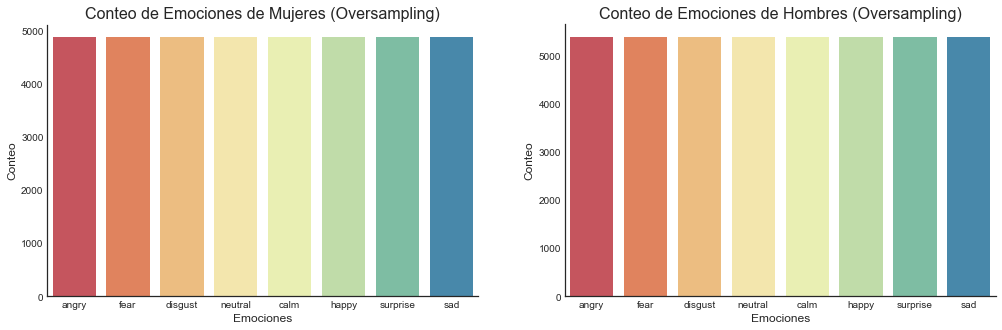

In [37]:
order = ['angry','fear','disgust','neutral','calm','happy','surprise','sad']

fig = plt.figure(figsize=(17, 5))

# Diagrama de barras de emociones de mujeres
fig.add_subplot(121)
plt.title('Conteo de Emociones de Mujeres (Oversampling)', size=16)
sns.countplot(female_Y, order = order, palette="Spectral")
plt.ylabel('Conteo', size=12)
plt.xlabel('Emociones', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Diagrama de barras de emociones de hombres
fig.add_subplot(122)
plt.title('Conteo de Emociones de Hombres (Oversampling)', size=16)
sns.countplot(male_Y, order = order, palette="Spectral")
plt.ylabel('Conteo', size=12)
plt.xlabel('Emociones', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Gráfico conjunto
plt.show()

In [40]:
# Comprobar el tamaño de los datos tras oversampling
uniqueF, countsF = np.unique(female_Y, return_counts=True)
uniqueM, countsM = np.unique(male_Y, return_counts=True)

print(f'Conteo de emociones:\nMujeres: {dict(zip(uniqueF, countsF))}\nHombres:   {dict(zip(uniqueM, countsM))}')

Conteo de emociones:
Mujeres: {'angry': 4872, 'calm': 4872, 'disgust': 4872, 'fear': 4872, 'happy': 4872, 'neutral': 4872, 'sad': 4872, 'surprise': 4872}
Hombres:   {'angry': 5369, 'calm': 5369, 'disgust': 5369, 'fear': 5369, 'happy': 5369, 'neutral': 5369, 'sad': 5369, 'surprise': 5369}


Ahora el modelo tendrá datos suficientes de cada categoría para poder realizar un aprendizaje equilibrado.

### Preparado de datos para el entrenamiento

Antes de proceder al entrenamiento de modelos, los datos deben ser preparados para su correcta ingesta.

Al tratarse de un problema de clasificación multi clase, y que los datos son categóricos, se aplica One-Hot Encoding a la etiqueta Y (las emociones), de tal manera que se crea una columna para cada valor distinto de las emociones que se están codificando y, para cada registro, marca con un 1 la columna a la que pertenezca dicho registro y dejar las demás con 0. Este es el formato adecuado para el entrenamiento.

In [41]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()

female_Y = encoder.fit_transform(np.array(female_Y).reshape(-1,1)).toarray()
male_Y = encoder.fit_transform(np.array(male_Y).reshape(-1,1)).toarray()

Hasta ahora se ha trabajado solo con los datos de mujeres y hombres por separado, pero es de interes poder hacer un modelo que trate con datos mixtos.

In [42]:
nogender_X = np.concatenate((female_X, male_X))
nogender_Y = np.concatenate((female_Y, male_Y))

# Separar en conjuntos de entrenamiento (80%) y test (20%)
x_train, x_test, y_train, y_test = train_test_split(nogender_X, nogender_Y, random_state=0, test_size=0.20, shuffle=True)
# Dimensiones de los datos finales
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((65542, 50), (65542, 8), (16386, 50), (16386, 8))

In [43]:
x_trainF, x_testF, y_trainF, y_testF = train_test_split(female_X, female_Y, random_state=0, test_size=0.20, shuffle=True)
x_trainF.shape, y_trainF.shape, x_testF.shape, y_testF.shape

((31180, 50), (31180, 8), (7796, 50), (7796, 8))

In [44]:
x_trainM, x_testM, y_trainM, y_testM = train_test_split(male_X, male_Y, random_state=0, test_size=0.20, shuffle=True)
x_trainM.shape, y_trainM.shape, x_testM.shape, y_testM.shape

((34361, 50), (34361, 8), (8591, 50), (8591, 8))

Para el escalado de datos, se utiliza el módulo StandarScaler(), que escala los datos siguiendo una distribución normal (distribución Gaussiana con media 0 y varianza unitaria):

Z=(X-μ)/σ

Al trabajar con modelos de Deep Learning, si las características no siguen esta distribución, el modelo puede resultar inestable y menos estable hacia los valores entrantes, desembocando en mayores errores de generalización. Para trabajar con los modelos descritos a continuación, también es necesario expandir la dimensión (+1) de los datos de entrada, para lo cual se utiliza la librería *numpy*.

In [45]:
# Escalado de datos
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_trainF = scaler.fit_transform(x_trainF)
x_testF = scaler.transform(x_testF)

x_trainM = scaler.fit_transform(x_trainM)
x_testM = scaler.transform(x_testM)

In [46]:
# Nuevas dimensiones del conjunto de entrenamiento mixto
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape , x_test.shape , y_test.shape

((65542, 50, 1), (65542, 8), (16386, 50, 1), (16386, 8))

In [47]:
# Nuevas dimensiones del conjunto de entrenamiento de mujeres
x_trainF = np.expand_dims(x_trainF, axis=2)
x_testF = np.expand_dims(x_testF, axis=2)
x_trainF.shape, y_trainF.shape, x_testF.shape, y_testF.shape

((31180, 50, 1), (31180, 8), (7796, 50, 1), (7796, 8))

In [48]:
# Nuevas dimensiones del conjunto de entrenamiento de hombres
x_trainM = np.expand_dims(x_trainM, axis=2)
x_testM = np.expand_dims(x_testM, axis=2)
x_trainM.shape, y_trainM.shape, x_testM.shape, y_testM.shape

((34361, 50, 1), (34361, 8), (8591, 50, 1), (8591, 8))

### Entrenamiento: Deep Learning con CNN y LSTM

Este proyecto aplica una solución hibrida entre una **CNN** (Convolutional Neural Network) y una RNN (Recurrent Neural Network), en concreto la **LSTM** (Long-Short Term Memory) tras haber obtenido los mejores resultados con la siguiente estructura.

In [49]:
# Construir el modelo
def build_model(in_shape):

    model=Sequential()
    model.add(Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(in_shape, 1)))
    model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [50]:
# Mostrar resumen del modelo
def model_build_summary(model_dim, train_features, val_features, val_labels):
    model = build_model(model_dim)
    model.summary()
    
    return model

In [51]:
# Función para mostrar curvas de evaluación de resultados (medidad accuracy y loss)
def show_graphs(history):
    epochs = [i for i in range(n_epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(30,12)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

Para optimizar los modelos se establecen y ajustan los hiperparametros.

In [52]:
# Reducir la tasa de aprendizaje cuando una métrica ha dejado de mejorar
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.000001)

# Número de ejemplos que se pasan al algoritmo en cada iteración de aprendizaje
batch_size = 48
# Número de veces que se usan todos los datos en el proceso de aprendizaje
n_epochs = 75

##### Modelo 1: Mixto

In [53]:
total_model = model_build_summary(x_train.shape[1], x_train, x_test, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 256)           1792      
_________________________________________________________________
average_pooling1d (AveragePo (None, 25, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 128)           196736    
_________________________________________________________________
average_pooling1d_1 (Average (None, 13, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           98432     
_________________________________________________________________
average_pooling1d_2 (Average (None, 7, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0

In [54]:
total_history = total_model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/75
1366/1366 [==============================] - 155s 114ms/step - loss: 1.4570 - accuracy: 0.4439 - val_loss: 1.2575 - val_accuracy: 0.5112
Epoch 2/75
1366/1366 [==============================] - 151s 111ms/step - loss: 1.2487 - accuracy: 0.5229 - val_loss: 1.1559 - val_accuracy: 0.5489
Epoch 3/75
1366/1366 [==============================] - 153s 112ms/step - loss: 1.1704 - accuracy: 0.5461 - val_loss: 1.1122 - val_accuracy: 0.5615
Epoch 4/75
1366/1366 [==============================] - 153s 112ms/step - loss: 1.1188 - accuracy: 0.5657 - val_loss: 1.0308 - val_accuracy: 0.5907
Epoch 5/75
1366/1366 [==============================] - 153s 112ms/step - loss: 1.0692 - accuracy: 0.5815 - val_loss: 0.9896 - val_accuracy: 0.6097
Epoch 6/75
1366/1366 [==============================] - 153s 112ms/step - loss: 1.0287 - accuracy: 0.6002 - val_loss: 0.9622 - val_accuracy: 0.6192
Epoch 7/75
1366/1366 [==============================] - 155s 113ms/step - loss: 0.9889 - accuracy: 0.6145 - val_

KeyboardInterrupt: 

In [ ]:
# Guardar el modelo y los weights (parametros utilizados en las capas del modelo)
model_name = 'Mixed_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
total_model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Guardar el modelo en el disco
model_json = total_model.to_json()
with open("Mixed_model03_json.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Valores del Accuracy durante entrenamiento y test (mixto)
score = total_model.evaluate(x_train,y_train, verbose = 0)
print("Accuracy del entrenamiento (mixto): {0:.2%}".format(score[1]))

score = total_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy del entrenamiento (mixto): {0:.2%}".format(score[1]))

In [ ]:
# Curvas de accuracy y loss durante las fases de entrenamiento y testeo (mixto)
show_graphs(history)

##### Modelo 2: Mujeres

In [ ]:
female_model = model_build_summary(x_trainF.shape[1], x_trainF, x_testF, y_testF)

In [ ]:
female_history = female_model.fit(x_trainF, y_trainF, batch_size=batch_size, epochs=n_epochs, validation_data=(x_testF, y_testF), callbacks=[rlrp])

In [ ]:
# Guardar el modelo y los weights (parametros utilizados en las capas del modelo)
model_name = 'Female_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
total_model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Guardar el modelo en el disco
model_json = total_model.to_json()
with open("Female_model_json.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Valores del Accuracy durante entrenamiento y test (mujeres)
score = female_model.evaluate(x_trainF,y_trainF, verbose = 0)
print("Accuracy del entrenamiento (mujeres): {0:.2%}".format(score[1]))

score = female_model.evaluate(x_testF, y_testF, verbose=0)
print("Accuracy del entrenamiento (mujeres): {0:.2%}".format(score[1]))

In [ ]:
# Curvas de accuracy y loss durante las fases de entrenamiento y testeo (mujeres)
show_graphs(history)

##### Modelo 3: Hombres

In [ ]:
male_model = model_build_summary(x_trainM.shape[1], x_trainM, x_testM, y_testM)

In [ ]:
male_history = male_model.fit(x_trainM, y_trainM, batch_size=batch_size, epochs=n_epochs, validation_data=(x_testM, y_testM), callbacks=[rlrp])

In [ ]:
# Guardar el modelo y los weights (parametros utilizados en las capas del modelo)
model_name = 'Male_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
total_model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Guardar el modelo en el disco
model_json = total_model.to_json()
with open("Male_model_json.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Valores del Accuracy durante entrenamiento y test (hombres)
score = male_model.evaluate(x_trainM,y_trainM, verbose = 0)
print("Accuracy del entrenamiento (hombres): {0:.2%}".format(score[1]))

score = male_model.evaluate(x_testM, y_testM, verbose=0)
print("Accuracy del entrenamiento (hombres): {0:.2%}".format(score[1]))

In [ ]:
# Curvas de accuracy y loss durante las fases de entrenamiento y testeo (hombres)
show_graphs(male_history)

Los mejores resultados los provee el modelo femenino, seguido por el masculino y el mixto. Esto sugiere que una división por sexo es beneficioso para esta tarea de clasificación de emociones.

### Predicciones

Una vez se da con la arquitectura que ofrece mayor eficacia, se pasa a la fase de testeo, durante la cual se analiza en detalle la capacidad de predicción del modelo. Para ello se emplea la matriz de confusión, a través de las cuales se identifica si existen confusiones específicas en la detección entre clases.

In [ ]:
def confusionMatrix(y_test_, y_pred, g):
    cm = confusion_matrix(y_test_, y_pred)
    plt.figure(figsize = (12, 10))
    cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Matriz de Confusión ({})'.format(g), size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

##### Predicciones: Mixto

In [ ]:
# Predicciones
pred_total = total_model.predict(x_test)
# Revertir predicciones para obtener las etiquetas iniciales
y_pred_total = encoder.inverse_transform(pred_total)
y_test_total = encoder.inverse_transform(y_test)

# Matriz de confusión para predicciones de datos mixtos
confusionMatrix(y_test_total, y_pred_total)

##### Predicciones: Mujeres

In [ ]:
pred_female = female_model.predict(x_testF)
y_pred_female = encoder.inverse_transform(pred_female)
y_test_female = encoder.inverse_transform(y_testF)

# Matriz de confusión para predicciones de datos mixtos
confusionMatrix(y_test_female, y_pred_female)

##### Predicciones: Hombres

In [ ]:
pred_male = male_model.predict(x_testM)
y_pred_male = encoder.inverse_transform(pred_male)
y_test_female = encoder.inverse_transform(y_testM)

# Matriz de confusión para predicciones de datos mixtos
confusionMatrix(y_test_female, y_pred_male)